In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.3.0


In [2]:
# Download the daset with keras.utils.get_file
dataset_path = keras.utils.get_file("housing.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data")

49152/49082 [==============================] - 0s 3us/step


In [3]:
column_names = ['CRIM','ZN','INDUS','CHAS','NOX',
                'RM', 'AGE', 'DIS','RAD','TAX','PTRATION', 'B', 'LSTAT', 'MEDV']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
# Create a dataset instant
dataset = raw_dataset.copy()

# This function returns last n rows from the object 
# based on position.
dataset.tail(n=10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATION,B,LSTAT,MEDV
496,0.28960,0.0,9.69,0,0.585,5.390,72.9,2.7986,6,391.0,19.2,396.90,21.14,19.7
497,0.26838,0.0,9.69,0,0.585,5.794,70.6,2.8927,6,391.0,19.2,396.90,14.10,18.3
498,0.23912,0.0,9.69,0,0.585,6.019,65.3,2.4091,6,391.0,19.2,396.90,12.92,21.2
499,0.17783,0.0,9.69,0,0.585,5.569,73.5,2.3999,6,391.0,19.2,395.77,15.10,17.5
500,0.22438,0.0,9.69,0,0.585,6.027,79.7,2.4982,6,391.0,19.2,396.90,14.33,16.8
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


In [4]:
# Split data into train/test
# p = training data portion
p=0.8
trainDataset = dataset.sample(frac=p,random_state=0)
testDataset = dataset.drop(trainDataset.index)

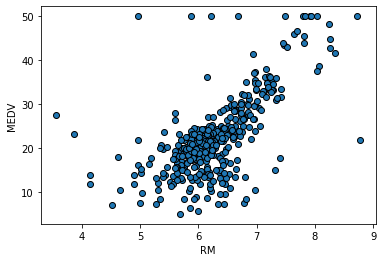

In [5]:
# Visual representation of training data
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# With .pop() command, the associated columns are extracted.
x = trainDataset['RM']
y = trainDataset['MEDV']
ax.scatter(x, y, edgecolors=(0, 0, 0))
ax.set_xlabel('RM')
ax.set_ylabel('MEDV')
plt.show()

In [6]:
# Pop command return item and drop it from frame.
# After using trainDataset.pop('RM'), the 'RM' column 
# does not exist in the trainDataset frame anymore!
trainInput = trainDataset['RM']
trainTarget = trainDataset['MEDV']
testInput = testDataset['RM']
testTarget = testDataset['MEDV']

In [7]:
# We don't specify anything for activation -> no activation is applied (ie. "linear" activation: a(x) = x)
# Check: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

def linear_model():
  model = keras.Sequential([
        layers.Dense(1, use_bias=True, input_shape=(1,), name='layer')
      ])

  # Using adam optimizer
  optimizer = tf.keras.optimizers.Adam(
      learning_rate=0.01, beta_1=0.9, beta_2=0.99, epsilon=1e-05, amsgrad=False,
      name='Adam')
    
  # Check: https://www.tensorflow.org/api_docs/python/tf/keras/Model
  # loss: String (name of objective function), objective function or tf.keras.losses.Loss instance. See tf.keras.losses.
  # optimizer: String (name of optimizer) or optimizer instance. See tf.keras.optimizers.
  # metrics: List of metrics to be evaluated by the model during training and testing
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])

  return model

# Create model instant
model = linear_model()

# Model plot
tf.keras.utils.plot_model(
  model, to_file='model.png', show_shapes=True, show_layer_names=True,
  rankdir='TB', expand_nested=False, dpi=100
  )

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [8]:
# params
n_epochs = 4000
batch_size = 256
n_idle_epochs = 100
n_epochs_log = 200
n_samples_save = n_epochs_log * trainInput.shape[0]
print('Checkpoint is saved for each {} samples'.format(n_samples_save))

# A mechanism that stops training if the validation loss is not improving for more than n_idle_epochs.
#See https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for details.
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.001)

# Creating a custom callback to print the log after a certain number of epochs
# Check: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
predictions_list = []
class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self,per_epoch=100):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.per_epoch = per_epoch
    
    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.per_epoch == 0:
        print('Epoch {}, loss {:.2f}, val_loss {:.2f}, mae {:.2f}, val_mae {:.2f}, mse {:.2f}, val_mse {:.2f}'\
              .format(epoch, logs['loss'], logs['val_loss'],logs['mae'], logs['val_mae'],logs['mse'], logs['val_mse']))
              
# Call the object
log_display = NEPOCHLogger(per_epoch=n_epochs_log)

# Include the epoch in the file name (uses `str.format`)
import os
checkpoint_path = "training/cp-{epoch:05d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=n_samples_save)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
  trainInput, trainTarget, batch_size=batch_size,
  epochs=n_epochs, validation_split = 0.1, verbose=0, callbacks=[earlyStopping,log_display,tensorboard_callback,checkpointCallback])

Checkpoint is saved for each 81000 samples
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Epoch 0, loss 917.43, val_loss 1022.65, mae 28.84, val_mae 30.14, mse 917.43, val_mse 1022.65
Epoch 200, loss 92.29, val_loss 142.37, mae 7.21, val_mae 8.70, mse 92.29, val_mse 142.37
Epoch 400, loss 55.87, val_loss 92.18, mae 5.37, val_mae 6.83, mse 55.87, val_mse 92.18
Epoch 600, loss 54.47, val_loss 91.38, mae 5.27, val_mae 6.76, mse 54.47, val_mse 91.38
Epoch 800, loss 52.66, val_loss 89.82, mae 5.19, val_mae 6.65, mse 52.66, val_mse 89.82
Epoch 1000, loss 51.01, val_loss 89.10, mae 5.06, val_mae 6.55, mse 51.01, val_mse 89.10
Epoch 1200, loss 49.54, val_loss 87.94, mae 4.98, val_mae 6.45, mse 49.54, val_mse 87.94
Epoch 1400, loss 48.24, val_loss 87.32, mae 4.89, val_mae 6.38, mse 48.24, val_mse 87.32
Epoch 1600, loss 47.17, val_loss 86.76, mae 4.81, val_mae 6.32, mse 47.17, val_mse 86.76
Epoch 1800, loss 46.20, val_loss 85.84, mae 4.76, val_mae 6.25, mse 46.20, val_ms

keys: dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


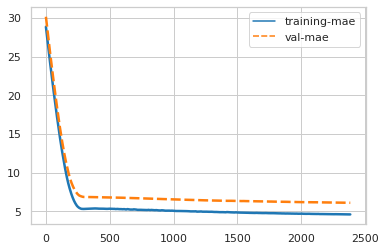

In [9]:
# The fit model returns the history object for each Keras model
# Let's explore what is inside history
print('keys:', history.history.keys())

# Returning the desired values for plotting and turn to numpy array
mae = np.asarray(history.history['mae'])
val_mae = np.asarray(history.history['val_mae'])

# Creating the data frame
num_values = (len(mae))
values = np.zeros((num_values,2), dtype=float)
values[:,0] = mae
values[:,1] = val_mae

# Using pandas to frame the data
steps = pd.RangeIndex(start=0,stop=num_values)
data = pd.DataFrame(values, steps, columns=["training-mae", "val-mae"])

# Plotting
sns.set(style="whitegrid")
sns.lineplot(data=data, palette="tab10", linewidth=2.5)

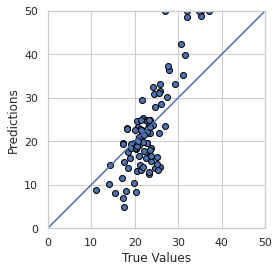

In [10]:
predictions = model.predict(testInput).flatten()
a = plt.axes(aspect='equal')
plt.scatter(predictions, testTarget, edgecolors=(0, 0, 0))
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [11]:
# Get the saved checkpoint files
checkpoints = []
for f_name in os.listdir(checkpoint_dir):
  if f_name.startswith('cp-'):
    file_with_no_ext = os.path.splitext(f_name)[0]
    checkpoints.append(file_with_no_ext)

# Return unique list elements
checkpoints = list(set(checkpoints))
print('checkpoints:',checkpoints)

# Load all model checkpoints and evaluate for each
count = 0
model_improvement_progress = False
if model_improvement_progress:
  for checkpoint in checkpoints:
    count += 1

    # Call model instant
    model = linear_model()
    
    # Restore the weights
    path = os.path.join('training',checkpoint)
    model.load_weights(path)

    # Access to layer weights
    layer = model.get_layer('layer')
    w1,w0 = layer.get_weights()
    w1 = float(w1[0])
    w0 = float(w0[0])
    
    # Draw the scatter plot of data
    fig, ax = plt.subplots()
    x = testInput
    y = testTarget
    ax.scatter(x, y, edgecolors=(0, 0, 0))
    ax.set_xlabel('RM')
    ax.set_ylabel('MEDV')
    
    # Plot the line
    y_hat = w1*x + w0
    plt.plot(x, y_hat, '-r')
    plt.savefig(os.path.join('/content/drive/linearregression', str(checkpoint)+'.png'))


checkpoints: ['cp-00000.ckpt']
